## Introduction

In this notebook, we will be building a model to predict drug interactions on the [ogbl-ddi](https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi) drug-drug interaction network and trying to match performance to the OGB Leaderboard for Link Property Prediction. Once we can re-create this using a baseline GraphSAGE architecture, we will substantially increase performance by adding [Jumping Knowledge](https://arxiv.org/abs/1806.03536) connections.

## What you need to do
### Basics

We'll start by implementing the GNN encoder model by stacking GraphSAGE layers to create node embeddings.  We'll then implement the Link Prediction decoder model, which takes two node embeddings as input and predicts whether or not those two nodes share an edge in the graph.  Sections you need to write code for will be marked with a "TODO" comment. For ease of troubleshooting, do not modify any of the code except where indicated until after the basics have been achieved.  We will also import functionality from the `utils.py` script.  No changes should be necessary to this file.

### Improvements

Once you have a correct implementation and can match leaderboard performance, we can move on to experimentation. In this section, we will implement Jumping Knowledge connections, which allows the GNN model to jointly consider information from multiple distances in the graph and gives substantial improvements above baseline GraphSAGE.

### Statistics

In each section, the `repeat_experiments` function is used to run the same model building process multiple times to collect statistics since there is significant variation in performance from run-to-run.  This allows us to make apples-to-apples comparisons to the leaderboard, but this process takes significant time.  Feel free to reduce from the default setup of 10 experiments with 200 epochs each to something much smaller (e.g., 1 experiment with 10 epochs) until you're confident in the implementation.


### Extra Credit

A great way to learn is to 1) read other peoples' code and 2) tinker. If you want to maximize your learning, the Extra Credit section will provide a few directions for further exploration. As part of this, it's recommended you find another submission on the OGB Leaderboard and try to re-create its submission. This will likely involve reading the paper and code, which is great practice. If you do something interesting and novel, we'll kindly host it in a public repo as an example of your glory (if you wish).


## Boilerplate

In [12]:
import os, sys
import math
from copy import deepcopy
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
print(f"Torch version: {th.__version__}.  CUDA version: {th.version.cuda}")

Torch version: 1.7.1.  CUDA version: 10.1


In [14]:
# Follow instructions at https://www.dgl.ai/pages/start.html
!{sys.executable} -m pip install dgl-cu101 -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [15]:
!{sys.executable} -m pip install ogb

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [16]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl.nn import SAGEConv, GraphConv
from dgl.dataloading import negative_sampler
import dgl.function as fn
from ogb.linkproppred import DglLinkPropPredDataset, Evaluator

In [17]:
dgl.__version__

'0.7.2'

In [18]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
device = th.device(device)
device

device(type='cuda')

## Helper functions

In [19]:
%load_ext autoreload
%autoreload 2

In [20]:
from utils import repeat_experiments, SAGE, norm_plot

# Basics
## Get OGB dataset and GraphSAGE leaderboard performance
We will use the `ogb` python package to download the data, give us the correct train/validation/test splits for proper comparison and an `Evaluator` to make sure performance is measured appropriately.  

In [21]:
dataset = DglLinkPropPredDataset(name="ogbl-ddi", root = 'dataset/')

In [22]:
# Values from the OGB leaderboard of GraphSAGE, submitted June 25, 2020
# HITS@20:  VAL = 0.6262 ± 0.0037;  TEST = 0.5390 ± 0.0474
val_hits_lb, val_hits_lb_std, test_hits_lb, test_hits_lb_std = 0.6262, 0.0037, 0.5390, 0.0474
evaluator = Evaluator(name = "ogbl-ddi")

In [23]:
# Extract split indices, DGL graph and labels
split_idx = dataset.get_edge_split()
g = dataset.graph[0]

In [24]:
src_orig, dst_orig = g.edges()
src_orig = src_orig.clone()
dst_orig = dst_orig.clone()

In [25]:
# Use a portion of the training edges for periodic evaluation
th.manual_seed(12345)
idx = th.randperm(split_idx['train']['edge'].size(0))
idx = idx[:split_idx['valid']['edge'].size(0)]
split_idx['eval_train'] = {'edge': split_idx['train']['edge'][idx]}

In [26]:
g

Graph(num_nodes=4267, num_edges=2135822,
      ndata_schemes={}
      edata_schemes={})

In [27]:
dataset.meta_info

eval metric                                                        hits@20
task type                                                  link prediction
download_name                                                          ddi
version                                                                  1
url                      http://snap.stanford.edu/ogb/data/linkproppred...
add_inverse_edge                                                      True
has_node_attr                                                        False
has_edge_attr                                                        False
split                                                               target
additional node files                                                 None
additional edge files                                                 None
is hetero                                                            False
binary                                                               False
Name: ogbl-ddi, dtype: ob

In [28]:
# Make sure none of the validation/test edges are in the graph used for training
assert g.has_edges_between(split_idx['valid']['edge'][:,0], split_idx['valid']['edge'][:,1]).sum().item()==0
assert g.has_edges_between(split_idx['test']['edge'][:,0], split_idx['test']['edge'][:,1]).sum().item()==0

## Approach overview
We will use a GNN for creating node embeddings, and then use a final Link Predictor model that takes a pair of embeddings as input and returns a prediction for whether or not those two nodes share an edge. 

We are going to train our model end-to-end by having it distinguish between true edges found in our training graph (i.e., "positive samples") and fake edges we generate by pairing random nodes (i.e., "negative samples").  We treat this "real vs fake" edge prediction task as a binary classification problem by giving the true edges a $y=1$ label and fake edges a $y=0$ label.  This is known as "contrastive loss".  For each minibatch, the training loop is like this:

- Calculate node embeddings for every node using the current GNN model parameters
  - This is standard message passing on the graph using the *training edges only*.  No edges from the validation/test set or fake edges are part of this message passing graph.
- Randomly sample a set of training edges (i.e., pairs of nodes in the training set) to construct the _positive samples_ and generate fake edges by randomly pairing nodes in the graph to construct the _negative samples_.  
  - In both cases, an edge sample is a pair of nodes like `(source_nodeId, destination_nodeId)`.
- Look-up the node embeddings for each of the source and destination nodes in the positive and negative samples
- Using the node embedding pairs and Link Predictor model, generate predictions for both the positive and negative edges: `pos_out` and `neg_out`, which represent probabilities that the node pairs have an edge in the graph
- Calculate a Binary Cross-Entropy loss where the positive edges have a label of 1 and negative a label of 0: 

$$ loss = -th.log(pos\_out).mean() - th.log(1 - neg\_out).mean() $$


In the above, I emphasize that the message passing graph is distinct from the edge-set we use for supervision and evaluation with the Link Predictor.  More specifically, the message passing graph uses the positive training edges only and does not have access to the validation/test edges nor does it use the negative edges for message passing.  The message passing graph is just used to calculate embeddings for the nodes.  The edge-set used for supervision and evaluation are a distinct concept: these are the node pairings sent to the Link Predictor and have implicit labels of "real or fake" that we can use for training and evaluation.  

Note that it's a form of information leak if you include an edge in message passing that you're also trying to use for prediction/supervision.  In a real-life scenario where you're trying to predict new edges, you will not have that edge as part of the graph to use in a message passing operation.


### Data description
This dataset consists of a homogeneous graph of 4k drug nodes and 1.3M edges that represent interactions in which taking the two drugs together gives a substantially different effect than taking them independently.  The edges are split into train, validation and test based on the proteins the drugs are designed to target in the body.  This means the drugs in the test set work differently than those in training and validation.  More details on the particulars of the dataset can be found on the [OGB dataset page](https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi).

## Model
### Node Features
In this case our drug nodes do not have natural features and we use 256-dimensional learnable features for each node.  These are input to the GNN to calculate embeddings and are jointly learned with the model parameters.

In [29]:
num_hidden = 256
emb = nn.Embedding(g.num_nodes(), num_hidden)

In [34]:
assert sum(p.numel() for p in emb.parameters()) == 1092352, "Number of embedding parameters doesn't match"

### GNN model architecture
Using the learnable features as input, the GNN model is a 2-layered GraphSAGE architecture where each layer $k$ updates the embedding $\mathbf{h}$ for node $i$ using the following equation:

$$\mathbf{h}^{(k+1)}_i = \sigma \left ( \mathbf{W}^{(k)}\text{concat} \left ( \mathbf{h}_i^{(k)}, \frac{1}{\left | \mathcal{N}_i \right |}\sum_{j \in \mathcal{N}_i}\mathbf{h}_{j}^{(k)}  \right ) \right )$$

This averages the neighborhood features $\frac{1}{\left | \mathcal{N}_i \right |}\sum_{j \in \mathcal{N}_i}\mathbf{h}_{j}^{(k)}$, concatenates to the current destination node embedding $\mathbf{h}_{i}^{(k)}$, applies a linear projection and finally a non-linear activation function. 

Interestingly, it can be shown that concatenating two vectors and applying a linear projection is equal to applying separate linear projections to each vector and adding the results.  This is demonstrated if you mentally carry out the matrix multiplication operations:

$$
\begin{bmatrix}
\leftarrow  \mathbf{h}_0  \rightarrow & \leftarrow  \mathbf{h}_{\mathcal{N}(0)}  \rightarrow \\
\leftarrow  \mathbf{h}_1  \rightarrow & \leftarrow  \mathbf{h}_{\mathcal{N}(1)}  \rightarrow 
\end{bmatrix} \begin{bmatrix}
\uparrow   &  \uparrow & & \uparrow \\
\mathbf{W}_0^h & \mathbf{W}_1^h  & \dots & \mathbf{W}_H^h \\
\downarrow & \downarrow & & \downarrow \\
\uparrow   &  \uparrow & & \uparrow \\
\mathbf{W}_0^\mathcal{N} & \mathbf{W}_{1}^\mathcal{N}  & \dots & \mathbf{W}_{H}^\mathcal{N} \\
\downarrow & \downarrow & & \downarrow 
\end{bmatrix} 
= \mathbf{H} \mathbf{W}^h + \mathbf{H}_\mathcal{N}\mathbf{W}^\mathcal{N}$$

In [PyG](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/sage_conv.html#SAGEConv) and [DGL](https://docs.dgl.ai/_modules/dgl/nn/pytorch/conv/sageconv.html#SAGEConv) implementations of GraphSAGE you see this second form of adding the result of separate linear projections:

$$ \mathbf{h}^{(k+1)}_i = \sigma \left ( \mathbf{W}^{(k)}_{self} \mathbf{h}_i^{(k)} + \mathbf{W}^{(k)}_{rel} \frac{1}{\left | \mathcal{N}_i \right |}\sum_{j \in \mathcal{N}_i}\mathbf{h}_{j}^{(k)} + \mathbf{b}^{(k)} \right )$$

Note that in the above equation I also added a bias term $\mathbf{b}$, which is commonly included.  We will implement this final form with the bias term.

In [31]:
class MySage(nn.Module):
    """
    This class implements a single GraphSAGE layer as given by 
    the final equation above
    """
    def __init__(self, in_channels, out_channels):
        super(MySage, self).__init__()
        # TODO
        """
        Create all the parameters in the final equation above.  Don't forget 
        to include the bias term.
        
        
        Arguments
        ----------
        in_channels : int
            Number of input features to the layer
        out_channels : int
            Number of desired output features from the layer
        """
        pass

    def reset_parameters(self):
        # TODO
        """
        A method that defines how to re-initialize all the parameters of
        your model.  This method will be invoked to start a new experiment,
        so it is important that all parameters are reset, or else there will 
        be an information leak between experiments.
        """
        pass
        
    def forward(self, g, x):
        # TODO
        """
        The forward pass of the model, which applies all of the layers
        according to the equation to a given graph and set of node features
        
        Note:  do NOT apply the final non-linearity in this method.  The
        appropriate non-linearity will be applied to the output of this class.
        This method should implement:
        
            W_self*h_i + W_neigh*h_neigh + b
        
        Arguments
        ----------
        g : DGLGraph
            The graph used for message passing
        x : Tensor
            The node features
        """
        pass

Your class will be passed as an argument to the `SAGE` wrapper class, defined in the `utils.py` script.  This class merely stacks together two layers of the class you have defined and adds the appropriate non-linearity, dropout...etc.

In [32]:
num_layers = 2
dropout = 0.5

model = SAGE(
    num_hidden, num_hidden, num_hidden, num_layers,
    dropout, sage_cls=MySage
)

In [39]:
assert sum(p.numel() for p in model.parameters()) == 262656, "Number of GNN model parameters doesn't match"

### Link Predictor architecture
Next you will implement a Link Predictor that takes two node embeddings as input and calculates an edge embedding $ \mathbf{e}_{u,v} $ via an element-wise product of the node embeddings:  

$$ \mathbf{e}_{u,v} = \mathbf{h}_u \odot \mathbf{h}_v$$

It then passes that result through a 2-layered dense Neural Network.

$$ \hat{y}_{u,v} = \text{sigmoid} \left( \mathbf{W}^1 \text{ReLU} \left(\mathbf{W}^0 \mathbf{e}_{u,v} + \mathbf{b}^0 \right) + \mathbf{b}^1 \right)$$

This output represents our predicted probability that two nodes share an edge.

In [36]:
class LinkPredictor(nn.Module):
    """
    This class implements a Link Predictor model
    """
    def __init__(self, in_channels, hidden_channels, out_channels, 
                 num_layers, dropout):
        super(LinkPredictor, self).__init__()
        # TODO
        """
        Define the Link Predictor architectural components.  Note that 
        dropout needs to be applied to the hidden layer representations
        
        
        Arguments
        ----------
        in_channels : int
            Number of input features to the layer
        hidden_channels : int
            Number of channels in the hidden layers
        out_channels : int
            Number of desired output features from the layer
        num_layers : int
            Number of dense neural network layers to apply to
            the edge embedding
        dropout : float
            Amount of dropout to apply to the hidden layers
        """

        pass

    def reset_parameters(self):
        # TODO
        """
        A method that defines how to re-initialize all the parameters of
        your model.  This method will be invoked to start a new experiment,
        so it is important that all parameters are reset, or else there will 
        be an information leak between experiments.
        """
        pass

    def forward(self, x_i, x_j):
        # TODO
        """
        The forward pass of the model, which calculates the edge embedding
        from the two node embeddings and applies the dense neural network
        layers.  This method will also implement the relevant non-linearities
        and dropout.
        
        Each hidden layer of the NN should have the flow:
            input -> linear -> ReLU -> Dropout
        
        The final layer of the NN should have the flow:
            input -> linear -> Sigmoid
            
        Note that there is no dropout applied to the final layer.
        
        Arguments
        ----------
        x_i : Tensor
            The source nodes' embeddings
        x_j : Tensor
            The destination nodes' embeddings
        """
        pass

In [37]:
predictor = LinkPredictor(
    num_hidden, num_hidden, 1,
    num_layers, dropout
)

In [40]:
assert sum(p.numel() for p in predictor.parameters()) == 66049, "Number of Link Predictor parameters doesn't match"

## Training
This will leverage functions defined in the `utils.py` script to standardize training and evaluation.  

For faster troubleshooting, note that you should be able to get close to the following performance within the first 10 training epochs, although it varies significantly from run to run:
```
Hits@10
Run: 01, Epoch: 10, Loss: 0.4170, Train: 21.47%, Valid: 18.70%, Test: 7.49%
Hits@20
Run: 01, Epoch: 10, Loss: 0.4170, Train: 28.53%, Valid: 25.24%, Test: 12.05%
Hits@30
Run: 01, Epoch: 10, Loss: 0.4170, Train: 31.95%, Valid: 28.63%, Test: 16.94%
```

In [27]:
# TODO: reduce this to something like 1 run for 10 epochs when developing
# and use 10 runs at 200 epochs for the final run
N_runs = 10
train_args = dict(epochs=200, lr=0.005, eval_steps=1, log_steps=1)

In [ ]:
loggers = repeat_experiments(
    g, emb, model, predictor, split_idx, 
    device, train_args, N_runs)

Hits@10
Run: 01, Epoch: 01, Loss: 1.1164, Train: 1.99%, Valid: 1.94%, Test: 3.31%
Hits@20
Run: 01, Epoch: 01, Loss: 1.1164, Train: 3.05%, Valid: 2.85%, Test: 4.55%
Hits@30
Run: 01, Epoch: 01, Loss: 1.1164, Train: 3.75%, Valid: 3.48%, Test: 5.26%
---
Hits@10
Run: 01, Epoch: 02, Loss: 0.7831, Train: 2.16%, Valid: 1.88%, Test: 0.11%
Hits@20
Run: 01, Epoch: 02, Loss: 0.7831, Train: 6.15%, Valid: 5.62%, Test: 3.39%
Hits@30
Run: 01, Epoch: 02, Loss: 0.7831, Train: 7.50%, Valid: 6.84%, Test: 4.77%
---
Hits@10
Run: 01, Epoch: 03, Loss: 0.6958, Train: 1.07%, Valid: 0.91%, Test: 0.39%
Hits@20
Run: 01, Epoch: 03, Loss: 0.6958, Train: 7.67%, Valid: 6.96%, Test: 6.00%
Hits@30
Run: 01, Epoch: 03, Loss: 0.6958, Train: 9.31%, Valid: 8.46%, Test: 8.38%
---
Hits@10
Run: 01, Epoch: 04, Loss: 0.6230, Train: 4.81%, Valid: 4.19%, Test: 0.68%
Hits@20
Run: 01, Epoch: 04, Loss: 0.6230, Train: 7.03%, Valid: 6.18%, Test: 4.87%
Hits@30
Run: 01, Epoch: 04, Loss: 0.6230, Train: 8.96%, Valid: 7.93%, Test: 11.10%
---

In [34]:
# Final performance
for key in loggers.keys():
    print(key)
    loggers[key].print_statistics()

Hits@10
All runs:
Highest Train: 73.77 ± 0.94
Highest Valid: 63.44 ± 0.97
  Final Train: 73.75 ± 0.95
   Final Test: 35.28 ± 11.36
Hits@20
All runs:
Highest Train: 78.22 ± 0.48
Highest Valid: 67.97 ± 0.47
  Final Train: 78.16 ± 0.52
   Final Test: 56.20 ± 12.88
Hits@30
All runs:
Highest Train: 79.92 ± 0.35
Highest Valid: 69.70 ± 0.32
  Final Train: 79.91 ± 0.35
   Final Test: 72.48 ± 5.89


In [49]:
# This comparison only makes sense if using ~200 epochs during training
norm_plot([
    (test_hits_lb, test_hits_lb_std, "GraphSAGE L.B."),
    (0.5620, 0.1288, 'GraphSAGE local'),
], 'Test Hits@20 Comparison over 10 runs')

In my experiments, I observe an average performance that's slightly above the leaderboard's, but with a standard deviation that's 3x as large.  

# Improvements with Jumping Knowledge connections
In this section we implement [Jumping Knowledge](https://arxiv.org/abs/1806.03536) connections, which allow the model to jointly consider information from different distances/hops from a node.  This is accomplished by aggregating all the intermedite representations of the GNN layers.  Before, we got a node's embedding for the downstream Link Predictor model by taking the output of the *last GNN layer*.  Now, we will directly aggregate the embeddings from *each GNN layer* and use this result as a node's final embedding.  This has a strong impact on the results for this task.

The original work presents a number of different ways of combining embeddings from multiple layers.  In our case, we will simply concatenate the embeddings of a node from each layer and then apply a linear projection:

$$ \mathbf{h}_i^{out} = \mathbf{W}^{out} \text{concat} \left( [ \mathbf{h}_i^0, \ldots, \mathbf{h}_i^K ] \right)$$

where $\mathbf{W}^{out}$ is a learnable projection matrix and $K$ is the number of GNN layers.

We will still use the SAGE layer created earlier in this project, but we will change how they are combined.  To get started, I have copy/pasted the `SAGE` model code we used above from the `utils.py` file and merely changed the class name.  Your task will be to modify the logic to include Jumping Knowledge connections and measure the impact.

In [41]:
class JKSAGE(nn.Module):
    """
    This class is copy/pasted from the SAGE class and needs to be modified
    to include Jumping Knowledge connections
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, sage_cls):
        super(JKSAGE, self).__init__()
        # TODO
        """
        Will need to add the linear projection.  Do not use a bias term
        for this final linear projection.
        
        
        Arguments
        ----------
        in_channels : int
            Number of input features to the layer
        hidden_channels : int
            Number of channels in the hidden layers
        out_channels : int
            Number of desired output features from the layer
        num_layers : int
            The number of GNN layers
        dropout : float
            The dropout rate to apply to the hidden layers
        sage_cls : nn.Module
            The torch Module object that implements GraphSAGE convolution
        """
        
        self.convs = nn.ModuleList()
        self.convs.append(sage_cls(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(sage_cls(hidden_channels, hidden_channels))
        self.convs.append(sage_cls(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        # TODO
        """
        Modify to include the new linear layer parameters
        """
        for conv in self.convs:
            conv.reset_parameters()
            
    @property
    def num_layers(self):
        return len(self.convs)
    
    def forward(self, gs, x):
        # TODO
        """
        The forward pass of the model, which needs to be modified to 
        include Jumping Knowledge connections.
        
        Note:  *Each* GraphSAGE layer should have this flow:
        
            input -> GraphSAGE -> ReLU -> Dropout
            
        This output of each layer will be used for concatenation.
        
        
        The final output of this method should be a linear projection 
        of the concatenated set of GNN outputs.  The result of this 
        final linear projection should be returned directly--no activation 
        or dropout should be applied.
        
        Arguments
        ----------
        gs : DGLGraph or list<DGLBlock>
            The graph or minibatch list of blocks used for message passing
        x : Tensor
            The node features
        """
        h = x

        for i, conv in enumerate(self.convs):
            if gs.is_block:
                g = gs[i]
            else:
                g = gs  # full graph
            h = conv(g, h)
            if i != len(self.convs) - 1:
                h = F.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)

        return h

In [42]:
model_jk = JKSAGE(
    num_hidden, num_hidden, num_hidden, num_layers,
    dropout, sage_cls=MySage,
)

In [44]:
assert sum(p.numel() for p in model_jk.parameters()) == 393728, "Number of JKSAGE parameters doesn't match"

In [ ]:
loggers_jk = repeat_experiments(
    g, emb, model_jk, predictor, split_idx, 
    device, train_args, N_runs)

In [35]:
for key in loggers_jk.keys():
    print(key)
    loggers_jk[key].print_statistics()

Hits@10
All runs:
Highest Train: 72.90 ± 1.19
Highest Valid: 63.51 ± 1.14
  Final Train: 72.89 ± 1.20
   Final Test: 22.91 ± 11.00
Hits@20
All runs:
Highest Train: 77.43 ± 0.57
Highest Valid: 67.92 ± 0.52
  Final Train: 77.42 ± 0.58
   Final Test: 67.11 ± 5.36
Hits@30
All runs:
Highest Train: 78.89 ± 0.33
Highest Valid: 69.36 ± 0.32
  Final Train: 78.88 ± 0.33
   Final Test: 75.47 ± 4.75


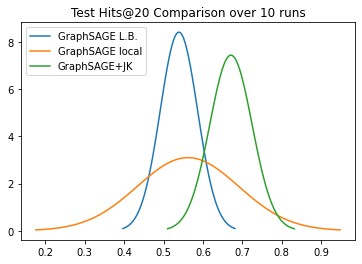

In [48]:
# This comparison only makes sense if using ~200 epochs during training
norm_plot([
    (test_hits_lb, test_hits_lb_std, "GraphSAGE L.B."),
    (0.5620, 0.1288, 'GraphSAGE local'),
    (.6711, .0536, 'GraphSAGE+JK')
], 'Test Hits@20 Comparison over 10 runs')

My experiments show a 25% relative performance improvement and a significantly reduced variation compared to my experiments without JK connections.

# Extra Credit
In general, it's a great use of time to find a submission on the leaderboard that's interesting and figure out how to implement it.  Here are two possible avenues for additional exploration:
1. In our Jumping Knowledge connections, instead of concatenating the embeddings of each layer and applying a linear projection to the result, we might instead aggregate our GNN-layer representations by applying an attention mechanism or an RNN, like an LSTM.  
2. We might extend our graph with high-confidence edges, as is proposed in the [Edge Proposal Set method](https://arxiv.org/abs/2106.15810).  In it, they essentially use a model to find the high-confidence edges ("Filter"), and then add those to the graph before running the actual Link Prediction task ("Rank").  In essence, they use a two-step approach in which the first step is pre-processing the graph to find new edges, and the second step runs as we have here, but now with a modified graph topology that will ideally improve performance.  This can be considered a form of "graph rewiring", in which the original graph is modified to facilitate better performance on a task.  